In [33]:
# setup 
# Add the src/ directory to the Python path so i can import my utils
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import calculate_transaction_metrics, calculate_grouped_metrics

# Initital analysis of the business problem
## Taking into account the actual orders supposed to multiple records per
## Adding onto the dataframe to be able to group by and analyse them
- If amount, country and card are the same AND between timestamp is <= 1 minute then it's the same order 

In [2]:
# retrieve intermediate data
df = pd.read_csv('../data/intermediate/clean_data.csv', index_col=False)
df.head()

,tmsp,country,amount,success,psp,3d_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [3]:
# Sort data by timestamp, looks sorted already, just to make sure
df['tmsp'] = pd.to_datetime(df['tmsp'])
df = df.sort_values(by='tmsp')

# Create a function to identify the same transaction
# aggregate by within one minute of previous where country, card, amount is the same 
def identify_transactions(df):
    # Shift the relevant columns to compare with the next row
    df['time_diff'] = df['tmsp'].diff().fillna(pd.Timedelta(seconds=0)) # To be able to be within the 1 minute limit
    df['same_transaction'] = ((df['country'] == df['country'].shift()) &
                               (df['amount'] == df['amount'].shift()) &
                               (df['card'] == df['card'].shift()) &
                               (df['time_diff'] <= pd.Timedelta(minutes=1)))

    # Create a transaction group identifier by cumulative sum
    df['order_id'] = (~df['same_transaction']).cumsum()

    return df

In [4]:
# Apply the function
df_transaction = identify_transactions(df)

# Show the result
display(df_transaction)

,tmsp,country,amount,success,psp,3d_secured,card,time_diff,same_transaction,order_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0 days 00:00:00,False,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0 days 00:00:06,True,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0 days 00:01:32,False,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0 days 00:00:24,True,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0 days 00:01:20,False,3
...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,0 days 00:00:00,True,27337
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,0 days 00:01:09,False,27338
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,0 days 00:00:16,True,27338
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,0 days 00:00:32,True,27338


In [5]:
# Added order_id bc of pointer, as expected
df.head()

,tmsp,country,amount,success,psp,3d_secured,card,time_diff,same_transaction,order_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0 days 00:00:00,False,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0 days 00:00:06,True,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0 days 00:01:32,False,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0 days 00:00:24,True,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0 days 00:01:20,False,3


In [6]:
total_orders = df['order_id'].nunique()
total_orders

27338

- there are 27338 order_id's

In [7]:
# Total orders
total_orders = df['order_id'].nunique()

# Group by order_id and calculate the max success for each order
order_success = df.groupby('order_id')['success'].max()

# Successful first attempts
df['first_attempt'] = df.groupby('order_id')['tmsp'].transform('min') == df['tmsp']
successful_first_attempts = df[df['first_attempt']]['success'].sum()

# Percentage of transactions that work on the first try
percentage_first_try_success = (successful_first_attempts / total_orders) * 100

print(f"Total number of orders: {total_orders}")
print(f"Number of successful transactions on the first attempt: {successful_first_attempts}")
print(f"Percentage of overall transactions that work on the first try: {percentage_first_try_success:.2f}%")


Total number of orders: 27338
Number of successful transactions on the first attempt: 5681
Percentage of overall transactions that work on the first try: 20.78%


- Overall it's not looking so good
    - only 20.63% of orders work on the first try
        - 4 out of 5 customers are experiencing issues with the payment

In [8]:
# clean up datafram 
display(df.columns)
df.drop(columns=['time_diff', 'first_attempt', 'same_transaction'], inplace=True)
display(df.columns)
display(df)

Index(['tmsp', 'country', 'amount', 'success', 'psp', '3d_secured', 'card',
       'time_diff', 'same_transaction', 'order_id', 'first_attempt'],
      dtype='object')

Index(['tmsp', 'country', 'amount', 'success', 'psp', '3d_secured', 'card',
       'order_id'],
      dtype='object')

,tmsp,country,amount,success,psp,3d_secured,card,order_id
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3
...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,27337
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,27338
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,27338
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,27338


## Taking into conisderation the timestamp

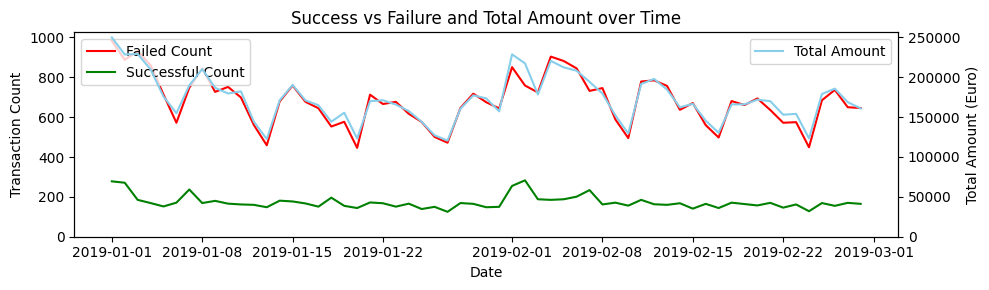

In [9]:
df['tmsp'] = pd.to_datetime(df['tmsp'])  \

# Group by timestamp and success/failure, then count
grouped = df.groupby([df['tmsp'].dt.date, 'success']).size().unstack(fill_value=0)
# Group by timestamp and success/failure, then sum the amount
amount_grouped = df.groupby([df['tmsp'].dt.date, 'success'])['amount'].sum().unstack(fill_value=0)

# Calculate the overall amount of orders (both successful and failed)
overall_amount_grouped = df.groupby(df['tmsp'].dt.date)['amount'].sum()

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot count of failed and successful transactions
ax1.plot(grouped.index, grouped[0], label='Failed Count', color='red', linestyle='-')  # Failed (success = 0)
ax1.plot(grouped.index, grouped[1], label='Successful Count', color='green', linestyle='-')  # Successful (success = 1)

# Create a second y-axis to plot the total amount of all orders
ax2 = ax1.twinx()
ax2.plot(amount_grouped.index, amount_grouped[0] + amount_grouped[1], label='Total Amount', color='skyblue', linestyle='-')  # Total Amount (success + failed)

# Set y-axis limits to start at 0
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

# Adding labels and legends
ax1.set_title('Success vs Failure and Total Amount over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transaction Count')
ax2.set_ylabel('Total Amount (Euro)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

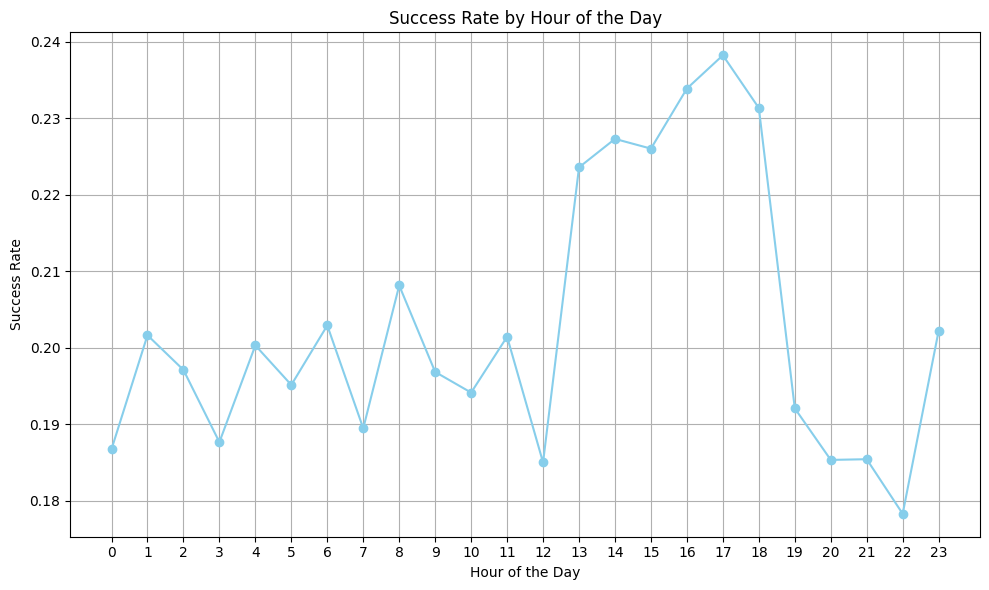

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'tmsp' is in datetime format
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Extract the hour of the day from the timestamp
df['hour_of_day'] = df['tmsp'].dt.hour

# Group by hour and calculate the success count and total transactions
hourly_grouped = df.groupby('hour_of_day')['success'].agg(['sum', 'count'])

# Calculate the success rate per hour
hourly_grouped['success_rate'] = hourly_grouped['sum'] / hourly_grouped['count']

# Plot the success rate by hour of the day
plt.figure(figsize=(10, 6))
hourly_grouped['success_rate'].plot(kind='line', marker='o', color='skyblue')

# Adding labels and title
plt.title('Success Rate by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Success Rate')
plt.xticks(range(24))  # Show all hours from 0 to 23
plt.grid(True)
plt.tight_layout()

plt.show()


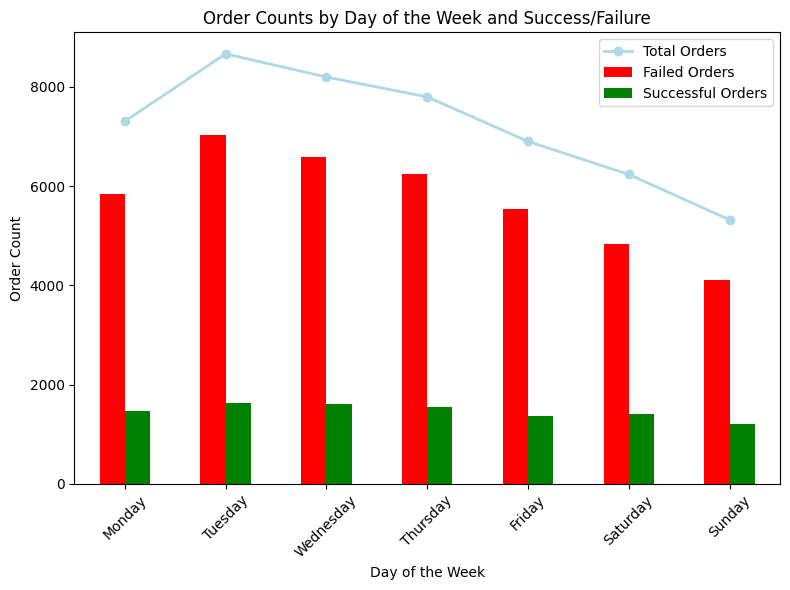

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your dataframe and tmsp is the timestamp column
df['tmsp'] = pd.to_datetime(df['tmsp'])  # Ensure tmsp is in datetime format

# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df['day_of_week'] = df['tmsp'].dt.dayofweek  # 0 is Monday, 6 is Sunday

# Group by day_of_week and success, then calculate the count of transactions
daily_grouped_count = df.groupby(['day_of_week', 'success']).size().unstack(fill_value=0)

# Map day_of_week to the corresponding day name for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_grouped_count.index = daily_grouped_count.index.map(lambda x: day_names[x])

# Calculate the total count per day (successful + failed)
total_counts = daily_grouped_count.sum(axis=1)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
daily_grouped_count.plot(kind='bar', stacked=False, ax=ax, color=['red', 'green'])

# Plot the total count line
ax.plot(daily_grouped_count.index, total_counts, label='Total Orders', color='lightblue', marker='o', linestyle='-', linewidth=2)

# Adding labels and legend
ax.set_title('Order Counts by Day of the Week and Success/Failure')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Order Count')
ax.legend(['Total Orders', 'Failed Orders', 'Successful Orders'])

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
daily_grouped_count

success,0,1
day_of_week,,
Monday,5835,1469
Tuesday,7036,1627
Wednesday,6590,1605
Thursday,6241,1555
Friday,5529,1370
Saturday,4836,1398
Sunday,4115,1204


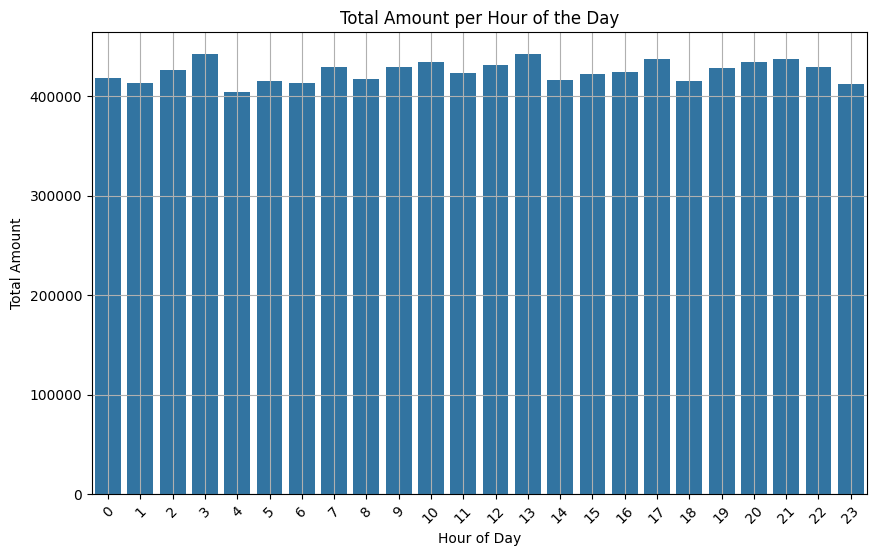

In [36]:
# Why are the sales similar at every hour of the day? That seams wrong since all countries are in the DACH region, same timezone
# I"m gonna asssume this is because the dataset is constructed 
# Group by hour_of_day and calculate the total amount per hour
hourly_total_amount = df.groupby('hour_of_day')['amount'].sum().reset_index()

# Calculate the average of these total amounts
average_total_amount_per_hour = hourly_total_amount['amount'].mean()

# Plot the total amount per hour
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_of_day', y='amount', data=hourly_total_amount)

plt.title('Total Amount per Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Analyzing the costs and loss of revenue
## Adding the fees the dataframe to be able to analyse the costs 

In [13]:
# add psp fees 
fee_mapping = {
    ('Moneycard', 1): 5,   # Successful transaction with Moneycard
    ('Moneycard', 0): 2,   # Failed transaction with Moneycard
    ('Goldcard', 1): 10,   # Successful transaction with Goldcard
    ('Goldcard', 0): 5,    # Failed transaction with Goldcard
    ('UK_Card', 1): 3,     # Successful transaction with UK_Card
    ('UK_Card', 0): 1,     # Failed transaction with UK_Card
    ('Simplecard', 1): 1,  # Successful transaction with Simplecard
    ('Simplecard', 0): 0.5 # Failed transaction with Simplecard
}

In [14]:
# Create a new column 'fee' by applying the fee mapping based on 'psp' and 'success'
df['fee'] = df.apply(lambda row: fee_mapping.get((row['psp'], row['success']), 0), axis=1)
df.head()

,tmsp,country,amount,success,psp,3d_secured,card,order_id,hour_of_day,day_of_week,fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,0,1,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1,0,1,3.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2,0,1,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,0,1,3.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3,0,1,0.5


In [15]:
# Filter for transactions (where success == 0 and == 1)
failed_transactions_df = df[df['success'] == 0]
successful_transactions_df = df[df['success'] == 1]

# Sum the 'fee' column for these  transactions
total_failed_fees = failed_transactions_df['fee'].sum()
total_success_fees = successful_transactions_df['fee'].sum()

print(f"Total fees for failed transactions attempts: {total_failed_fees} Euro")
print(f"Total fees for successful transactions attempts: {total_success_fees} Euro")

Total fees for failed transactions attempts: 49045.0 Euro
Total fees for successful transactions attempts: 39499.0 Euro


In [16]:
# Group by 'order_id' and sum 'amount' and 'fees'
grouped = df.groupby("order_id").agg({
    "amount": "first",  
    "fee": "sum",      
    "country": "first",
    "card": "first",
    "success": "sum"
}).reset_index()

# Call the function with the grouped DataFrame
metrics = calculate_transaction_metrics(grouped)

# Show results as DF
results = pd.DataFrame({
    'Metric per Order': ['Amount Sum', 'Fees Sum', 'Average Amount', 'Transaction Count', 'Average Fees per Transaction', 'Fees to Amount Ratio (%)', 'Success Percentage %'],
    'Successful Orders': [metrics['Amount Sum (Successful)'], metrics['Fees Sum (Successful)'], metrics['Average Amount (Successful)'], metrics['Transaction Count (Successful)'], metrics['Average Fees per Transaction (Successful)'], metrics['Fees to Amount Ratio (%) (Successful)'], metrics['Success Percentage % (Successful)']],
    'Unsuccessful Orders': [metrics['Amount Sum (Unsuccessful)'], metrics['Fees Sum (Unsuccessful)'], metrics['Average Amount (Unsuccessful)'], metrics['Transaction Count (Unsuccessful)'], metrics['Average Fees per Transaction (Unsuccessful)'], metrics['Fees to Amount Ratio (%) (Unsuccessful)'], metrics['Success Percentage % (Unsuccessful)']]
})

pd.set_option('display.float_format', '{:,.1f}'.format)
display(results)

,Metric per Order,Successful Orders,Unsuccessful Orders
0,Amount Sum,"1,899,260.0","3,618,644.0"
1,Fees Sum,"50,177.0","38,346.0"
2,Average Amount,185.8,211.5
3,Transaction Count,"10,222.0","17,113.0"
4,Average Fees per Transaction,4.9,2.2
5,Fees to Amount Ratio (%),2.6,1.1
6,Success Percentage %,37.4,62.6


    - 62.6% of orders don't go through and abandon the cart 
        - high loss of revenue 
        - the transaction fees should not be the biggest concern here 
        - customers abandon the cart on average on the second try
        -- should not get to it -- we need a high chance of success

- The total fees from failed transactions are higher than those from successful transactions, even though failed transactions have a lower mean fee (341.95 to 391.88)
- spread of amounts is quite large for both successful and failed orders, showing that there is significant variability in the amounts for both categories
    - number of failed transactions (17,113) is significantly higher than the number of successful transactions (10,225)
    - revenue possibly lost from failed transactions (€8,301,338) is over 4 times higher than the revenue earned from successful transactions (€1,901,430)
    - highlights the high potential cost of failed transactions to the business.
    - fees for successful transactions (€4.91) are more than double those for failed ones (€2.24) 
        - in line with the fee structure provided
        - 50% of failed transaction fees lie between €1.00 and €3.00
        - 50% of successful transaction fees lie between €3.00 and €6.00


In [17]:
# get metrics per psp
psp_df = calculate_grouped_metrics(df, 'psp') 
display(psp_df)

,psp,Amount Sum (Successful),Fees Sum (Successful),Amount Sum (Unsuccessful),Fees Sum (Unsuccessful),Average Amount (Successful),Average Amount (Unsuccessful),Transaction Count (Successful),Transaction Count (Unsuccessful),Average Fees per Transaction (Successful),Average Fees per Transaction (Unsuccessful),Fees to Amount Ratio (%) (Successful),Fees to Amount Ratio (%) (Unsuccessful),Success Percentage % (Successful),Success Percentage % (Unsuccessful),Amount Percentage of Total (%),Transaction Count Percentage of Total (%)
0,UK_Card,569405,"9,730.0",2830109,"27,013.0",175.6,209.2,3243,13531,3.0,2.0,1.7,1.0,19.3,80.7,44.2,44.1
1,Simplecard,330456,"1,687.0",1819442,"5,520.0",196.0,202.1,1686,9002,1.0,0.6,0.5,0.3,15.8,84.2,28.0,28.1
2,Moneycard,318520,"8,120.0",1183721,"13,919.0",196.1,203.3,1624,5823,5.0,2.4,2.5,1.2,21.8,78.2,19.5,19.6
3,Goldcard,260198,"12,680.0",374927,"9,875.0",205.2,201.9,1268,1857,10.0,5.3,4.9,2.6,40.6,59.4,8.3,8.2


In [18]:
# get metrics per card
card_df = calculate_grouped_metrics(df, 'card') 
display(card_df)

,card,Amount Sum (Successful),Fees Sum (Successful),Amount Sum (Unsuccessful),Fees Sum (Unsuccessful),Average Amount (Successful),Average Amount (Unsuccessful),Transaction Count (Successful),Transaction Count (Unsuccessful),Average Fees per Transaction (Successful),Average Fees per Transaction (Unsuccessful),Fees to Amount Ratio (%) (Successful),Fees to Amount Ratio (%) (Unsuccessful),Success Percentage % (Successful),Success Percentage % (Unsuccessful),Amount Percentage of Total (%),Transaction Count Percentage of Total (%)
0,Visa,232004,"4,774.0",1051445,"15,556.0",188.6,205.4,1230,5119,3.9,3.0,2.1,1.5,19.4,80.6,23.3,23.2
1,Diners,228058,"4,882.0",839526,"12,926.0",190.0,207.0,1200,4055,4.1,3.2,2.1,1.5,22.8,77.2,19.3,19.2
2,Master,606863,"13,537.0",2561093,"36,869.0",189.1,204.5,3209,12525,4.2,2.9,2.2,1.4,20.4,79.6,57.4,57.6


In [19]:
# get metrics per country
country_df = calculate_grouped_metrics(df, 'country')  
display(country_df)

,country,Amount Sum (Successful),Fees Sum (Successful),Amount Sum (Unsuccessful),Fees Sum (Unsuccessful),Average Amount (Successful),Average Amount (Unsuccessful),Transaction Count (Successful),Transaction Count (Unsuccessful),Average Fees per Transaction (Successful),Average Fees per Transaction (Unsuccessful),Fees to Amount Ratio (%) (Successful),Fees to Amount Ratio (%) (Unsuccessful),Success Percentage % (Successful),Success Percentage % (Unsuccessful),Amount Percentage of Total (%),Transaction Count Percentage of Total (%)
0,Germany,636160,"13,876.0",2657100,"39,105.5",188.0,205.7,3384,12918,4.1,3.0,2.2,1.5,20.8,79.2,59.7,59.6
1,Austria,207365,"4,495.0",879310,"12,686.5",187.5,204.8,1106,4293,4.1,3.0,2.2,1.4,20.5,79.5,19.7,19.7
2,Switzerland,223400,"4,822.0",915654,"13,559.0",194.4,204.0,1149,4488,4.2,3.0,2.2,1.5,20.4,79.6,20.6,20.6


In [20]:
# Group by 'country' and 'card', counting the number of transactions (order_id)
grouped = df.groupby(["country", "card"]).agg(transaction_count=("order_id", "count")).reset_index()

# Group by 'country' - get total per country
country_totals = grouped.groupby("country")["transaction_count"].sum().reset_index()
country_totals = country_totals.rename(columns={"transaction_count": "total_transactions"})

# Merge all countries
grouped = pd.merge(grouped, country_totals, on="country")

# Calculate the percentage of card usage within each country
grouped["card_usage_percentage %"] = (grouped["transaction_count"] / grouped["total_transactions"] * 100)

# Reorder for better readability
columns_order = ['country', 'card', 'card_usage_percentage %', 'transaction_count', 'total_transactions']
grouped = grouped[columns_order]

pd.set_option('display.float_format', '{:,.1f}'.format)
display(grouped)

,country,card,card_usage_percentage %,transaction_count,total_transactions
0,Austria,Diners,19.6,1927,9839
1,Austria,Master,57.9,5700,9839
2,Austria,Visa,22.5,2212,9839
3,Germany,Diners,19.0,5747,30233
4,Germany,Master,57.6,17428,30233
5,Germany,Visa,23.3,7058,30233
6,Switzerland,Diners,20.3,2094,10338
7,Switzerland,Master,56.8,5874,10338
8,Switzerland,Visa,22.9,2370,10338


In [21]:
# save corrected data 
df.to_csv('../data/intermediate/clean_data_with_order_and_fees.csv', index=False)

# Findings

## Overall Performance
- Only **20.63% of orders succeed on the first attempt**, meaning **4 out of 5 customers** experience issues with payments.

## Daily Success Rates
- Success rates vary slightly by day, with no significant improvement observed across the week.
- **Monday** sees the highest volume of both successful (1469) and failed (5835) transactions, while **Sunday** has the lowest total orders, with **1204 successful** and **4115 failed**.
- **Friday** has the second-highest volume of transactions, with **1370 successful** and **5529 failed**, indicating a higher failure rate at the end of the week.
- The **success rate** remains relatively constant throughout the week, with only minor variations.

## Hourly Patterns
- Success rates hover around **20% throughout the day**.
- A **slight increase in success rates** is observed between **13:00 (20%) and 18:00 (23.4%)**, suggesting this period may be more reliable for transactions.

## Transaction Metrics
- **Total fees for failed transactions**: €49,045.
- **Total fees for successful transactions**: €39,499.
- **Successful orders**:
  - Amount sum: €1,899,260.
  - Average amount per transaction: €185.8.
  - Fees to amount ratio: **2.6%**.
  - Success percentage: **37.4%**.
- **Unsuccessful orders**:
  - Amount sum: €3,618,644.
  - Average amount per transaction: €211.5.
  - Fees to amount ratio: **1.1%**.
  - Failure percentage: **62.6%**.

## By Payment Service Providers (PSPs)
- **UK_Card** has the highest unsuccessful transaction volume (80.7%) and accounts for **44.2% of total transactions**. Fees for successful transactions with **UK_Card** are **3 Euros**, while failed transactions incur a fee of **1 Euro**.
- **Simplecard** has a relatively lower fee structure. It charges **1 Euro** for successful transactions and **0.5 Euro** for failed ones. It accounts for **28.0% of total transactions**.
- **Moneycard** handles a good volume of transactions but charges higher fees: **5 Euros** for successful transactions and **2 Euros** for failed ones. It contributes **19.5% of total transactions**.
- **Goldcard** shows the best success rates (40.6%), with a fee of **10 Euros** for successful transactions and **5 Euros** for failed transactions. It has the lowest transaction volume at **8.3% of total transactions**.


## By Card Type
- **MasterCard** accounts for the largest share of transactions (57.4%) but shows a high failure percentage (**79.6%**).
- **Diners** and **Visa** follow similar trends, with failure rates above **77%**.

## By Country
- **Germany** accounts for the majority of transactions (**59.7%**) but has a failure rate of **79.2%**.
- **Switzerland** and **Austria** show similar trends with **failure rates above 79%**.
